In [1]:

# LangGraph官方文档教程
# https://langchain-ai.github.io/langgraph/tutorials/get-started/3-add-memory/




In [2]:
# Add memory¶  添加内存 ¶
# The chatbot can now use tools to answer user questions, but it does not remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.
# 聊天机器人现在可以使用工具来回答用户的问题，但它无法记住之前交互的上下文。这限制了它进行连贯、多轮对话的能力。

# LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.
# LangGraph 通过持久化检查点解决了这个问题。如果您在编译图时提供 checkpointer ，并在调用图时提供 thread_id ，LangGraph 会在每一步之后自动保存状态。当您使用相同的 thread_id 再次调用该图时，该图会加载其已保存的状态，从而允许聊天机器人从上次中断的地方继续运行。

# We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But first, let's add checkpointing to enable multi-turn conversations.
# 我们稍后会看到， 检查点比简单的聊天记忆功能强大得多 ——它允许您随时保存和恢复复杂的状态，以进行错误恢复、人机交互、时间旅行交互等等。但首先，让我们添加检查点来实现多轮对话。


In [3]:
# Note  笔记

# This tutorial builds on Add tools.
# 本教程以添加工具为基础。

In [4]:
# pip install -U "langchain[google-genai]"

In [5]:
import getpass
import os
from langchain.chat_models import init_chat_model

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [6]:
# Add tools教程的代码
# https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/
# ChatbotWithTavilySearch.ipynb中的代码


from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# graph = graph_builder.compile()





In [7]:
# 1. Create a MemorySaver checkpointer¶
# 1. 创建 MemorySaver 检查点 ¶
# Create a MemorySaver checkpointer:
# 创建 MemorySaver 检查点：

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [9]:
# This is in-memory checkpointer, which is convenient for the tutorial. However, in a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect a database.
# 这是内存检查点，这对于本教程来说很方便。但是，在生产应用程序中，您可能会将其更改为使用 SqliteSaver 或 PostgresSaver 并连接数据库。


In [10]:
# 2. Compile the graph¶
# 2. 编译图表 ¶
# Compile the graph with the provided checkpointer, which will checkpoint the State as the graph works through each node:
# 使用提供的检查点编译图表，当图表通过每个节点时，它将检查 State ：

In [11]:
graph = graph_builder.compile(checkpointer=memory)

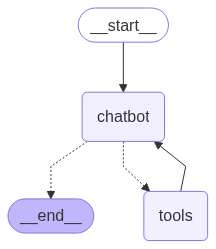

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
# 3. Interact with your chatbot¶
# 3. 与你的聊天机器人互动 ¶
# Now you can interact with your bot!
# 现在您可以与您的机器人互动！

In [14]:
# 1.Pick a thread to use as the key for this conversation.
# 选择一个线索作为本次对话的关键。

In [15]:
config = {"configurable": {"thread_id": "1"}}

In [16]:
# 2.Call your chatbot:  呼叫您的聊天机器人：

In [17]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will, nice to meet you! Is there anything I can help you with today?


In [18]:
# Note  笔记

# The config was provided as the second positional argument when calling our graph. It importantly is not nested within the graph inputs ({'messages': []}).
# 调用我们的图时，配置作为第二个位置参数提供。重要的是，它没有嵌套在图输入中（ {'messages': []} ）。

In [19]:
# 4. Ask a follow up question¶
# 4. 提出后续问题 ¶
# Ask a follow up question:
# 提出后续问题：

In [20]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will.


In [21]:
# Notice that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this LangSmith trace to see what's going on.
# 请注意 ，我们没有使用外部列表来管理内存：所有操作都由检查点处理！您可以查看 LangSmith 跟踪中的完整执行过程，了解具体发生了什么。

# Don't believe me? Try this using a different config.
# 不相信？试试其他配置。

In [22]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I do not store any personal information. Therefore, I don't remember your name.


In [23]:
# Notice that the only change we've made is to modify the thread_id in the config. See this call's LangSmith trace for comparison.
# 请注意 ，我们所做的唯一更改是修改了配置中的 thread_id 。请参阅此调用的 LangSmith 跟踪以进行比较。

In [24]:
# 5. Inspect the state¶
# 5. 检查状态 ¶
# By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).
# 到目前为止，我们已经在两个不同的线程上创建了几个检查点。但是检查点都包含哪些内容呢？要随时检查给定配置的图表 state ，请调用 get_state(config) 。

In [25]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='0e651f84-addd-4feb-b3df-e9b9350dea2f'), AIMessage(content='Hi Will, nice to meet you! Is there anything I can help you with today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--e127dd8d-658c-4707-b766-397b21ac7858-0', usage_metadata={'input_tokens': 507, 'output_tokens': 19, 'total_tokens': 526, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='6a215410-f31d-45c6-ac9a-dee1df89797a'), AIMessage(content='Yes, your name is Will.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--a536be

In [26]:
# StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='8c1ca919-c553-4ebf-95d4-b59a2d61e078'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?", additional_kwargs={}, response_metadata={'id': 'msg_01WTQebPhNwmMrmmWojJ9KXJ', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 405, 'output_tokens': 32}}, id='run-58587b77-8c82-41e6-8a90-d62c444a261d-0', usage_metadata={'input_tokens': 405, 'output_tokens': 32, 'total_tokens': 437}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='daba7df6-ad75-4d6b-8057-745881cea1ca'), AIMessage(content="Of course, I remember your name, Will. I always try to pay attention to important details that users share with me. Is there anything else you'd like to talk about or any questions you have? I'm here to help with a wide range of topics or tasks.", additional_kwargs={}, response_metadata={'id': 'msg_01E41KitY74HpENRgXx94vag', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 444, 'output_tokens': 58}}, id='run-ffeaae5c-4d2d-4ddb-bd59-5d5cbf2a5af8-0', usage_metadata={'input_tokens': 444, 'output_tokens': 58, 'total_tokens': 502})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef7d06e-93e0-6acc-8004-f2ac846575d2'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content="Of course, I remember your name, Will. I always try to pay attention to important details that users share with me. Is there anything else you'd like to talk about or any questions you have? I'm here to help with a wide range of topics or tasks.", additional_kwargs={}, response_metadata={'id': 'msg_01E41KitY74HpENRgXx94vag', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 444, 'output_tokens': 58}}, id='run-ffeaae5c-4d2d-4ddb-bd59-5d5cbf2a5af8-0', usage_metadata={'input_tokens': 444, 'output_tokens': 58, 'total_tokens': 502})]}}, 'step': 4, 'parents': {}}, created_at='2024-09-27T19:30:10.820758+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef7d06e-859f-6206-8003-e1bd3c264b8f'}}, tasks=())

In [27]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

In [28]:
# The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.
# 上面的快照包含当前状态值、相应的配置以及 next 要处理的节点。在我们的例子中，图已达到 END 状态，因此 next 为空。

# Congratulations! Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles arbitrarily complex graph states, which is much more expressive and powerful than simple chat memory.
# 恭喜！ 借助 LangGraph 的检查点系统，您的聊天机器人现在可以跨会话保持对话状态。这为更自然、更符合情境的交互开辟了激动人心的可能性。LangGraph 的检查点甚至可以处理任意复杂的图状态 ，这比简单的聊天记忆更具表现力和功能强大得多。

In [31]:
# 修改后的 stream_graph_updates 函数
def stream_graph_updates(user_input: str):
    # graph.stream(..., stream_mode="values") 返回的每个 'event' 就是一个状态字典
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values",
    ):
        # 直接从 event 字典中获取 'messages' 列表
        # 并且检查 'messages' 键是否存在且不为空，以避免潜在错误
        if "messages" in event and event["messages"]:
            # 获取列表中的最后一个消息，并调用 pretty_print() 方法
            # pretty_print() 方法会根据消息类型进行格式化输出，这通常是LangChain/LangGraph推荐的方式
            event["messages"][-1].pretty_print()
        else:
            # 如果 event 中没有 messages 或者 messages 为空，可以打印一个提示
            # 这可能发生在某些中间步骤，例如仅触发工具调用而没有立即生成AI回复时
            print("Assistant: [Processing... or No direct message output yet]")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except Exception as e:
        # 捕获所有异常，并提供一个回退机制
        print(f"An error occurred: {e}. Falling back to a default query.")
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


User:  你好，我是Miku


================================ Human Message =================================

你好，我是Miku
================================== Ai Message ==================================

你好，Miku！很高兴认识你。有什么我可以帮你的吗？(Hello Miku! Nice to meet you. Is there anything I can help you with?)


User:  你还记得我是谁吗？


================================ Human Message =================================

你还记得我是谁吗？
================================== Ai Message ==================================

是的，你是 Miku。(Yes, you are Miku.)


User:  我最喜欢斋藤飞鸟。


================================ Human Message =================================

我最喜欢斋藤飞鸟。
================================== Ai Message ==================================

我知道你最喜欢斋藤飞鸟。有什么关于她的事情你想了解吗？(I know that you like Saito Asuka the best. Is there anything you want to know about her?)


User:  你记得我最喜欢谁吗？


================================ Human Message =================================

你记得我最喜欢谁吗？
================================== Ai Message ==================================

是的，你最喜欢斋藤飞鸟。(Yes, you like Saito Asuka the best.)


User:  quit


Goodbye!


In [ ]:
# Next steps¶  下一步
# In the next tutorial, you will add human-in-the-loop to the chatbot to handle situations where it may need guidance or verification before proceeding.
# 在下一个教程中，您将向聊天机器人添加人机交互功能 ，以处理在继续之前可能需要指导或验证的情况。